#Install Pennylane

In [164]:
!pip install pennylane

#Import necessary modules

In [165]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#Initialize hyperparameters

In [170]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset
n_qbits = 9

SAVE_PATH = "/content/drive/MyDrive/Work/Baylor/Quantum Computing/Project" # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
ADV_PREPROCESS = False
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

#Download MNIST dataset

In [167]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

#Implement quanalutional layer

In [127]:
dev = qml.device("default.qubit", wires=n_qbits)
# Random circuit parameters

In [ ]:
filters_param = []
for i in range(5):
  rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qbits))
  filters_param.append(rand_params)
np.save(SAVE_PATH + '/weights/quantum_layer.npy', filters_param)

In [168]:
filters_param = np.load(SAVE_PATH + '/weights/quantum_layer.npy')

In [129]:
@qml.qnode(dev)
def circuit(phi, rand_params):
  n_phi = len(phi)
  for j in range(n_phi):
      qml.RY(np.pi * phi[j], wires=j)

  RandomLayers(rand_params, wires=list(range(n_phi)))

  return [qml.expval(qml.PauliZ(j)) for j in range(n_phi)]

def quanv(image, n_filters, kernel, stride):
    """Convolves the input image with many applications of the same quantum circuit."""
    h = image.shape[0]
    w = image.shape[1]
    d = image.shape[2]
    out_h = ((h-kernel)//stride) + 1
    out_w = ((w-kernel)//stride) + 1
    out = np.zeros((out_h, out_w, n_filters*d))

    for j in range(0, h - kernel + 1, stride):
        for k in range(0, w - kernel + 1, stride):            
            for filter_inx in range(n_filters):
              for i in range(d):
                sub_image = []
                for m in range(kernel):
                  for n in range(kernel):
                    sub_image.append(int(image[j+m, k+n, i] >= 0.5))
                q_results = circuit(sub_image, filters_param[filter_inx]) 
                out[j // stride, k // stride, i + filter_inx*d] = np.mean(q_results)
    return out


#Implement CW Attack

In [169]:
def get_pred_ans(model, image, quantum):
  if (quantum):
    pred = model.predict(tf.reshape(quanv(image, 5, 3, 1), (1, image.shape[0], image.shape[1], image.shape[2])))[0]
  else:
    pred = model.predict(tf.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2])))[0]
  return tf.argmax(pred)

def loss_for_cw(model, x, inx_tgt, quantum, targeted=False, conf=0):
  re_x = tf.reshape(x,(1,x.shape[0], x.shape[1], x.shape[2]))
  if (quantum):
    pred = model(tf.reshape(quanv(x,5 ,3, 1),(1, x.shape[0], x.shape[1], x.shape[2])))
  else:
    pred = model(re_x)
  max = -9999
  for i in range(pred.shape[1]):
    if (i != inx_tgt and pred[0][i] >= max):
      max = pred[0][i]
  if (targeted):
    return tf.maximum(max - pred[0][inx_tgt], conf)
  else:
    return tf.maximum(pred[0][inx_tgt] - max, conf)

def cw(model, input_image, inx_tgt, max_iter, step_size, quantum=False, masked=None, targeted=False):
  if(masked == None):
    masked = tf.ones(input_image.shape)
  if (not targeted):
    new_label = inx_tgt
  else:
    new_label, new_confidence = get_class_confidence(input_image)
  w_ = tf.atanh(input_image*2 - 1) + 0.00001
  c = 0.01
  loss1 = 15
  while ((((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt)) and c <= 100):
    i = 0
    while (i < max_iter and (((not targeted) and new_label == inx_tgt) or (targeted and new_label != inx_tgt))):
      with tf.GradientTape() as tape:
        tape.watch(w_)
        adv = tf.cast((tf.tanh(w_) + 1.0)/2.0, tf.float32)
        adv = input_image + (adv - input_image)*masked
        loss1 = tf.norm((adv-input_image)*masked)
        loss2 = loss_for_cw(model, adv, inx_tgt, targeted=targeted, quantum=quantum)
        loss = loss1 + c*loss2
      gradient = tape.gradient(loss, w_)
      w_ = w_ - step_size*gradient
      adv = tf.cast((tf.tanh(w_) + 1.0)/2.0, tf.float32)
      adv = input_image + (adv - input_image)*masked
      new_label = get_pred_ans(model, adv, quantum=quantum)
      #print('new label: {}, loss1: {}, loss2: {}'.format(new_label, loss1, loss2))
      i += 1
    c *= 2
  return adv, tf.norm(adv - input_image), c

#Preprocessing for a quanalutional layer

In [171]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("\r{}/{}        ".format(idx + 1, n_train), end='')
        q_train_images.append(quanv(img,5,3,1))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("\r{}/{}        ".format(idx + 1, n_test), end="")
        q_test_images.append(quanv(img,5,3,1))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "/5_3_1_q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "/5_3_1_q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "/5_3_1_q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "/5_3_1_q_test_images.npy")

#Show the result after quanolutional layer

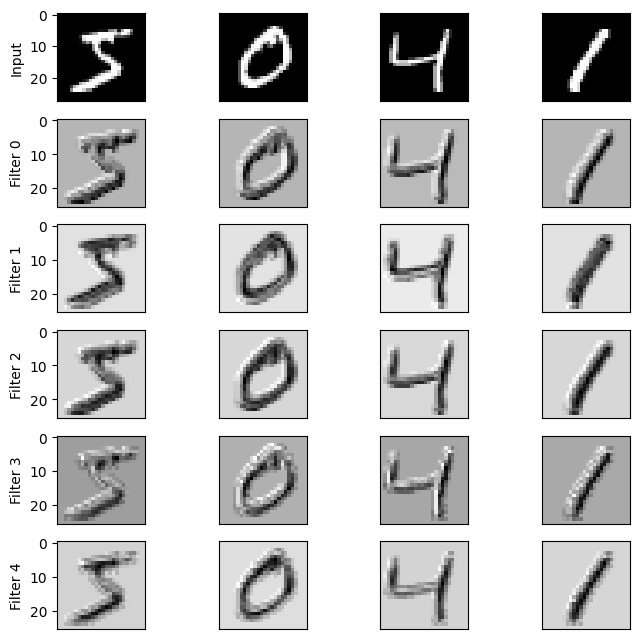

<Figure size 640x480 with 0 Axes>

In [163]:
n_samples = 4
n_channels = 5
plt.rcParams.update({'font.size': 10, 'lines.linewidth': 3})
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(8, 8))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")    
    axes[0, k].xaxis.set_visible(False)
    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Filter {}".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)   
            axes[c+ 1, k].yaxis.set_visible(False)            
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")         
        axes[c + 1, k].xaxis.set_visible(False)      
#plt.tight_layout()
plt.show()
plt.savefig(SAVE_PATH + '/figures/result_q_layers.png', bbox_inches='tight', dpi=350)

#Experiment on linear classifier

In [172]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

##Implement and train quantum linear model

In [ ]:
q_model = MyModel()

In [17]:
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.8234 - accuracy: 0.1200 - val_loss: 1.9215 - val_accuracy: 0.3667
Epoch 2/30
13/13 - 0s - loss: 1.5951 - accuracy: 0.5800 - val_loss: 1.6051 - val_accuracy: 0.5333
Epoch 3/30
13/13 - 0s - loss: 1.0041 - accuracy: 0.7800 - val_loss: 1.4770 - val_accuracy: 0.4333
Epoch 4/30
13/13 - 0s - loss: 0.5679 - accuracy: 0.9000 - val_loss: 1.2168 - val_accuracy: 0.7000
Epoch 5/30
13/13 - 0s - loss: 0.4758 - accuracy: 0.9400 - val_loss: 1.1642 - val_accuracy: 0.6667
Epoch 6/30
13/13 - 0s - loss: 0.4006 - accuracy: 0.9200 - val_loss: 1.1341 - val_accuracy: 0.6667
Epoch 7/30
13/13 - 0s - loss: 0.2771 - accuracy: 1.0000 - val_loss: 1.0694 - val_accuracy: 0.6667
Epoch 8/30
13/13 - 0s - loss: 0.1936 - accuracy: 1.0000 - val_loss: 1.0194 - val_accuracy: 0.7000
Epoch 9/30
13/13 - 0s - loss: 0.1670 - accuracy: 1.0000 - val_loss: 1.0110 - val_accuracy: 0.7000
Epoch 10/30
13/13 - 0s - loss: 0.1356 - accuracy: 1.0000 - val_loss: 1.0134 - val_accuracy: 0.6667
Epoch 11/30
13/13 -

In [84]:
q_model.save_weights(SAVE_PATH + '/weights/q_linear.h5')

In [176]:
q_model.load_weights(SAVE_PATH + '/weights/q_linear.h5')

##Implement and train classical linear model

In [19]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3920 - accuracy: 0.1000 - val_loss: 2.3593 - val_accuracy: 0.0333
Epoch 2/30
13/13 - 0s - loss: 2.0247 - accuracy: 0.2600 - val_loss: 2.1961 - val_accuracy: 0.1000
Epoch 3/30
13/13 - 0s - loss: 1.7295 - accuracy: 0.5200 - val_loss: 2.0452 - val_accuracy: 0.2000
Epoch 4/30
13/13 - 0s - loss: 1.4920 - accuracy: 0.7400 - val_loss: 1.8979 - val_accuracy: 0.3000
Epoch 5/30
13/13 - 0s - loss: 1.2813 - accuracy: 0.8800 - val_loss: 1.7643 - val_accuracy: 0.5000
Epoch 6/30
13/13 - 0s - loss: 1.1111 - accuracy: 0.9000 - val_loss: 1.6653 - val_accuracy: 0.5000
Epoch 7/30
13/13 - 0s - loss: 0.9656 - accuracy: 0.9200 - val_loss: 1.5896 - val_accuracy: 0.5667
Epoch 8/30
13/13 - 0s - loss: 0.8459 - accuracy: 0.9400 - val_loss: 1.5169 - val_accuracy: 0.6333
Epoch 9/30
13/13 - 0s - loss: 0.7474 - accuracy: 0.9400 - val_loss: 1.4564 - val_accuracy: 0.7000
Epoch 10/30
13/13 - 0s - loss: 0.6632 - accuracy: 0.9600 - val_loss: 1.4129 - val_accuracy: 0.7000
Epoch 11/30
13/13 -

In [85]:
c_model.save_weights(SAVE_PATH + '/weights/c_linear.h5')

In [178]:
c_model.load_weights(SAVE_PATH + '/weights/c_linear.h5')

##Plot results

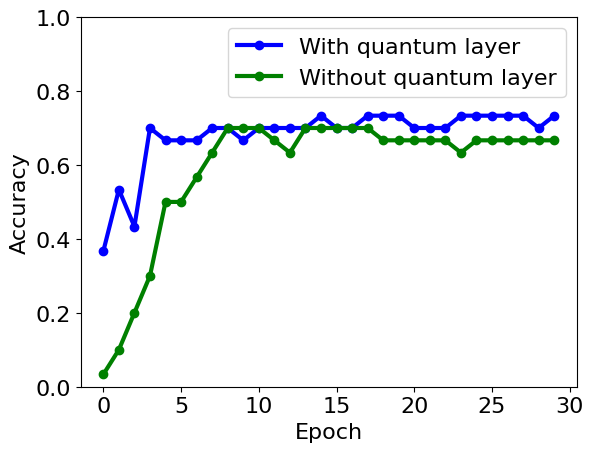

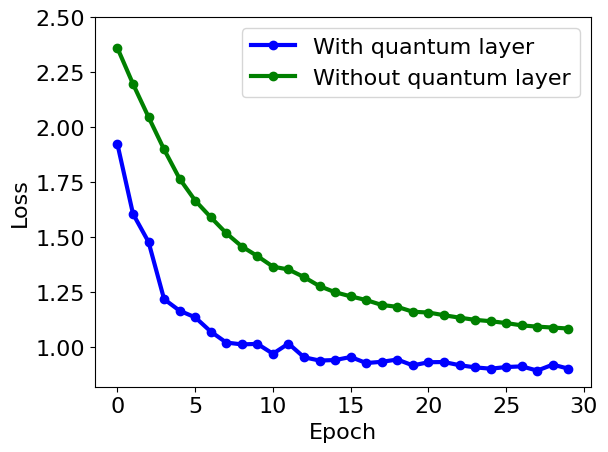

In [54]:
#plt.style.use("seaborn")
plt.rcParams.update({'font.size': 16, 'lines.linewidth': 3})

plt.figure()
plt.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
plt.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xlabel("Epoch")
plt.legend()
plt.savefig(SAVE_PATH + '/figures/linear_accuracy.pdf', bbox_inches='tight', dpi=350)

plt.figure()
plt.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
plt.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
plt.ylabel("Loss")
plt.ylim(top=2.5)
plt.xlabel("Epoch")
plt.legend()
plt.savefig(SAVE_PATH + '/figures/linear_loss.pdf', bbox_inches='tight', dpi=350)

## Create adversarial examples

In [75]:
adv_linear_dataset = []
adv_linear_label = []
for inx, image in enumerate(test_images):
  print("\r{} of {}".format(inx+1, len(test_images)), end='')
  pred_label = tf.argmax(c_model.predict(tf.reshape(image,(1,28,28,1)))[0])
  if (pred_label == test_labels[inx]):
    adv, _, _ = cw(c_model, image, test_labels[inx],20,0.01)
    adv_linear_dataset.append(adv)
    adv_linear_label.append(test_labels[inx])

30 of 30

In [76]:
adv_linear_dataset = np.asarray(adv_linear_dataset)
adv_linear_label = np.asarray(adv_linear_label)

In [77]:
np.save(SAVE_PATH + "/adv_linear_dataset.npy", adv_linear_dataset)
np.save(SAVE_PATH + "/adv_linear_label.npy", adv_linear_label)

In [179]:
adv_linear_dataset = np.load(SAVE_PATH + "/adv_linear_dataset.npy")
adv_linear_label = np.load(SAVE_PATH + "/adv_linear_label.npy")

#Experiment on CNN

In [180]:
def MyCNNModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        #keras.layers.Input(shape=(14,14,5)),
        keras.layers.Conv2D(filters=3, kernel_size=3,strides=(3,3)),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

##Implement and train quantum CNN model

In [47]:
q_cnnmodel = MyCNNModel()

q_cnn_history = q_cnnmodel.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.4965 - accuracy: 0.0600 - val_loss: 2.3488 - val_accuracy: 0.0000e+00
Epoch 2/30
13/13 - 0s - loss: 2.3115 - accuracy: 0.0400 - val_loss: 2.2541 - val_accuracy: 0.0333
Epoch 3/30
13/13 - 0s - loss: 2.1939 - accuracy: 0.0800 - val_loss: 2.1834 - val_accuracy: 0.0667
Epoch 4/30
13/13 - 0s - loss: 2.0896 - accuracy: 0.1400 - val_loss: 2.1126 - val_accuracy: 0.1000
Epoch 5/30
13/13 - 0s - loss: 1.9765 - accuracy: 0.2000 - val_loss: 2.0120 - val_accuracy: 0.3000
Epoch 6/30
13/13 - 0s - loss: 1.8535 - accuracy: 0.2600 - val_loss: 1.9200 - val_accuracy: 0.3667
Epoch 7/30
13/13 - 0s - loss: 1.6930 - accuracy: 0.3800 - val_loss: 1.8183 - val_accuracy: 0.4667
Epoch 8/30
13/13 - 0s - loss: 1.5344 - accuracy: 0.4800 - val_loss: 1.7082 - val_accuracy: 0.6000
Epoch 9/30
13/13 - 0s - loss: 1.3528 - accuracy: 0.5800 - val_loss: 1.5790 - val_accuracy: 0.6000
Epoch 10/30
13/13 - 0s - loss: 1.1745 - accuracy: 0.7200 - val_loss: 1.4881 - val_accuracy: 0.6667
Epoch 11/30
13/

In [86]:
q_cnnmodel.save_weights(SAVE_PATH + '/weights/q_cnn.h5')

In [182]:
q_cnnmodel.load_weights(SAVE_PATH + '/weights/q_cnn.h5')

##Implement and train classical CNN model

In [25]:
c_cnnmodel = MyCNNModel()

c_cnn_history = c_cnnmodel.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3380 - accuracy: 0.0400 - val_loss: 2.2734 - val_accuracy: 0.0667
Epoch 2/30
13/13 - 0s - loss: 2.2468 - accuracy: 0.1200 - val_loss: 2.2421 - val_accuracy: 0.1000
Epoch 3/30
13/13 - 0s - loss: 2.1623 - accuracy: 0.1600 - val_loss: 2.2114 - val_accuracy: 0.1667
Epoch 4/30
13/13 - 0s - loss: 2.0839 - accuracy: 0.2800 - val_loss: 2.1741 - val_accuracy: 0.2000
Epoch 5/30
13/13 - 0s - loss: 1.9943 - accuracy: 0.4800 - val_loss: 2.1303 - val_accuracy: 0.2333
Epoch 6/30
13/13 - 0s - loss: 1.9014 - accuracy: 0.6000 - val_loss: 2.0845 - val_accuracy: 0.3000
Epoch 7/30
13/13 - 0s - loss: 1.7936 - accuracy: 0.6600 - val_loss: 2.0312 - val_accuracy: 0.3333
Epoch 8/30
13/13 - 0s - loss: 1.6786 - accuracy: 0.7400 - val_loss: 1.9673 - val_accuracy: 0.4000
Epoch 9/30
13/13 - 0s - loss: 1.5543 - accuracy: 0.7600 - val_loss: 1.9029 - val_accuracy: 0.4333
Epoch 10/30
13/13 - 0s - loss: 1.4301 - accuracy: 0.7600 - val_loss: 1.8389 - val_accuracy: 0.4333
Epoch 11/30
13/13 -

In [87]:
c_cnnmodel.save_weights(SAVE_PATH + '/weights/c_cnn.h5')

In [184]:
c_cnnmodel.load_weights(SAVE_PATH + '/weights/c_cnn.h5')

##Plot results

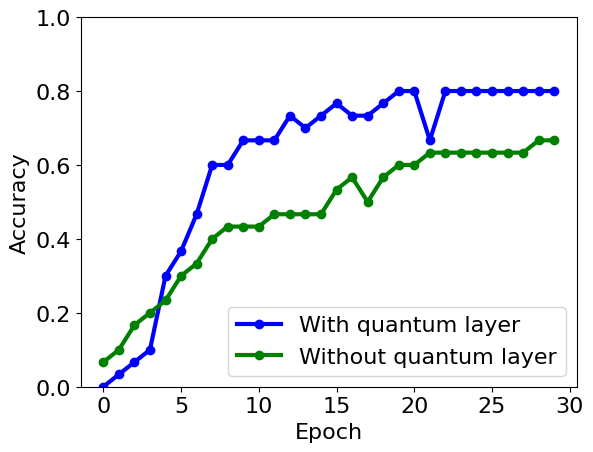

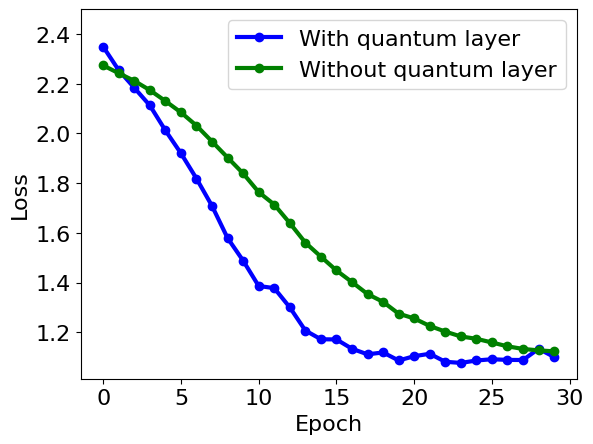

In [53]:
plt.style.use("default")
plt.rcParams.update({'font.size': 16, 'lines.linewidth': 3})

plt.figure()
plt.plot(q_cnn_history.history["val_accuracy"], "-ob", label="With quantum layer")
plt.plot(c_cnn_history.history["val_accuracy"], "-og", label="Without quantum layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xlabel("Epoch")
plt.legend()
plt.savefig(SAVE_PATH + '/figures/cnn_accuracy.pdf', bbox_inches='tight', dpi=350)

plt.figure()
plt.plot(q_cnn_history.history["val_loss"], "-ob", label="With quantum layer")
plt.plot(c_cnn_history.history["val_loss"], "-og", label="Without quantum layer")
plt.ylabel("Loss")
plt.ylim(top=2.5)
plt.xlabel("Epoch")
plt.legend()
plt.savefig(SAVE_PATH + '/figures/cnn_loss.pdf', bbox_inches='tight', dpi=350)

##Create adversarial examples

In [78]:
adv_cnn_dataset = []
adv_cnn_label = []
for inx, image in enumerate(test_images):
  print("\r{} of {}".format(inx+1, len(test_images)), end='')
  pred_label = tf.argmax(c_cnnmodel.predict(tf.reshape(image,(1,28,28,1)))[0])
  if (pred_label == test_labels[inx]):
    adv, _, _  = cw(c_cnnmodel, image, test_labels[inx],20,0.01)
    adv_cnn_dataset.append(adv)
    adv_cnn_label.append(test_labels[inx])

30 of 30

In [79]:
adv_cnn_dataset = np.asarray(adv_cnn_dataset)
adv_cnn_label = np.asarray(adv_cnn_label)

In [83]:
np.save(SAVE_PATH + "/adv_cnn_dataset.npy", adv_cnn_dataset)
np.save(SAVE_PATH + "/adv_cnn_label.npy", adv_cnn_label)

In [185]:
adv_cnn_dataset = np.load(SAVE_PATH + "/adv_cnn_dataset.npy")
adv_cnn_label = np.load(SAVE_PATH + "/adv_cnn_label.npy")

#Experiment on CNN with classical convolutional layer equivalent to the quanvolutional layer

In [186]:
def MyCNN2Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        #keras.layers.Input(shape=(14,14,5)),
        keras.layers.Conv2D(filters=5, kernel_size=3,strides=(1,1)),
        keras.layers.Conv2D(filters=3, kernel_size=3,strides=(3,3)),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

##Implement and train classical 2-CNN model

In [45]:
c_cnn2model = MyCNN2Model()

c_cnn2_history = c_cnn2model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.2841 - accuracy: 0.0800 - val_loss: 2.2205 - val_accuracy: 0.2333
Epoch 2/30
13/13 - 0s - loss: 2.1970 - accuracy: 0.1400 - val_loss: 2.1867 - val_accuracy: 0.3000
Epoch 3/30
13/13 - 0s - loss: 2.1081 - accuracy: 0.2800 - val_loss: 2.1501 - val_accuracy: 0.3333
Epoch 4/30
13/13 - 0s - loss: 2.0171 - accuracy: 0.3200 - val_loss: 2.0994 - val_accuracy: 0.3333
Epoch 5/30
13/13 - 0s - loss: 1.8966 - accuracy: 0.3600 - val_loss: 2.0329 - val_accuracy: 0.4000
Epoch 6/30
13/13 - 0s - loss: 1.7610 - accuracy: 0.4800 - val_loss: 1.9467 - val_accuracy: 0.4333
Epoch 7/30
13/13 - 0s - loss: 1.5815 - accuracy: 0.5600 - val_loss: 1.8398 - val_accuracy: 0.4333
Epoch 8/30
13/13 - 0s - loss: 1.3749 - accuracy: 0.6600 - val_loss: 1.7044 - val_accuracy: 0.5000
Epoch 9/30
13/13 - 0s - loss: 1.1455 - accuracy: 0.7400 - val_loss: 1.5605 - val_accuracy: 0.4667
Epoch 10/30
13/13 - 0s - loss: 0.9190 - accuracy: 0.8200 - val_loss: 1.4379 - val_accuracy: 0.5667
Epoch 11/30
13/13 -

In [89]:
c_cnn2model.save_weights(SAVE_PATH + '/weights/q_cnn2.h5')

In [188]:
c_cnn2model.load_weights(SAVE_PATH + '/weights/q_cnn2.h5')

##Plot results

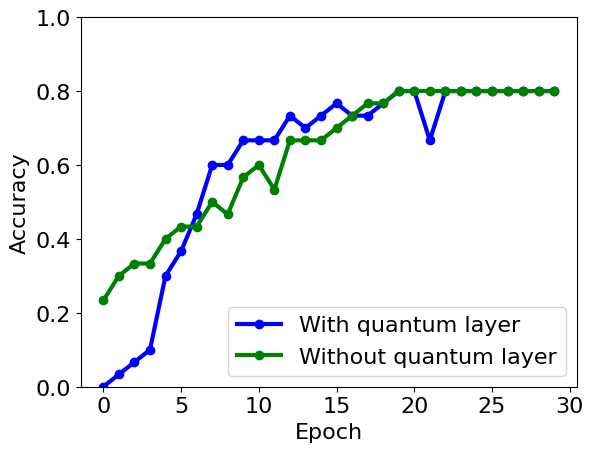

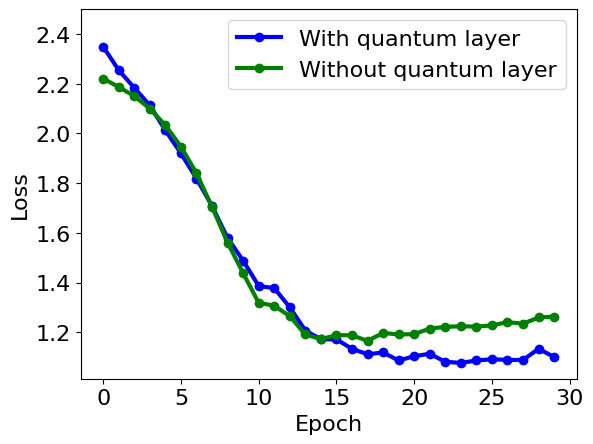

In [52]:
plt.style.use("default")
plt.rcParams.update({'font.size': 16, 'lines.linewidth': 3})

plt.figure()
plt.plot(q_cnn_history.history["val_accuracy"], "-ob", label="With quantum layer")
plt.plot(c_cnn2_history.history["val_accuracy"], "-og", label="Without quantum layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xlabel("Epoch")
plt.legend()
plt.savefig(SAVE_PATH + '/figures/cnn2_accuracy.pdf', bbox_inches='tight', dpi=350)

plt.figure()
plt.plot(q_cnn_history.history["val_loss"], "-ob", label="With quantum layer")
plt.plot(c_cnn2_history.history["val_loss"], "-og", label="Without quantum layer")
plt.ylabel("Loss")
plt.ylim(top=2.5)
plt.xlabel("Epoch")
plt.legend()
plt.savefig(SAVE_PATH + '/figures/cnn2_loss.pdf', bbox_inches='tight', dpi=350)

##Create adversarial examples

In [96]:
adv_cnn2_dataset = []
adv_cnn2_label = []
for inx, image in enumerate(test_images):
  print("\r{} of {}".format(inx+1, len(test_images)), end='')
  pred_label = tf.argmax(c_cnn2model.predict(tf.reshape(image,(1,28,28,1)))[0])
  if (pred_label == test_labels[inx]):
    adv, _, _  = cw(c_cnn2model, image, test_labels[inx],20,0.01)
    adv_cnn2_dataset.append(adv)
    adv_cnn2_label.append(test_labels[inx])

30 of 30

In [97]:
adv_cnn2_dataset = np.asarray(adv_cnn2_dataset)
adv_cnn2_label = np.asarray(adv_cnn2_label)

In [99]:
np.save(SAVE_PATH + "/adv_cnn2_dataset.npy", adv_cnn2_dataset)
np.save(SAVE_PATH + "/adv_cnn2_label.npy", adv_cnn2_label)

In [189]:
adv_cnn2_dataset = np.load(SAVE_PATH + "/adv_cnn2_dataset.npy")
adv_cnn2_label = np.load(SAVE_PATH + "/adv_cnn2_label.npy")

#Evaluate all the models with all adversarial dataset

##Preprocessing for quantum adversarial examples from the classical ones

In [190]:
if ADV_PREPROCESS == True:
    q_adv_linear_dataset = []
    print("Quantum pre-processing of adversarial examples of linear model:")
    for idx, img in enumerate(adv_linear_dataset):
        print("\r{}/{}        ".format(idx + 1, len(adv_linear_dataset)), end='')
        q_adv_linear_dataset.append(quanv(img,5,3,1))
    q_adv_linear_dataset = np.asarray(q_adv_linear_dataset)

    # Save pre-processed images
    np.save(SAVE_PATH + "/q_adv_linear_dataset.npy", q_adv_linear_dataset)

    q_adv_cnn_dataset = []
    print("\nQuantum pre-processing of adversarial examples of cnn model:")
    for idx, img in enumerate(adv_cnn_dataset):
        print("\r{}/{}        ".format(idx + 1, len(adv_cnn_dataset)), end='')
        q_adv_cnn_dataset.append(quanv(img,5,3,1))
    q_adv_cnn_dataset = np.asarray(q_adv_cnn_dataset)

    # Save pre-processed images
    np.save(SAVE_PATH + "/q_adv_cnn_dataset.npy", q_adv_cnn_dataset)

    q_adv_cnn2_dataset = []
    print("\nQuantum pre-processing of adversarial examples of cnn2 model:")
    for idx, img in enumerate(adv_cnn2_dataset):
        print("\r{}/{}        ".format(idx + 1, len(adv_cnn2_dataset)), end='')
        q_adv_cnn2_dataset.append(quanv(img,5,3,1))
    q_adv_cnn2_dataset = np.asarray(q_adv_cnn2_dataset)

    # Save pre-processed images
    np.save(SAVE_PATH + "/q_adv_cnn2_dataset.npy", q_adv_cnn2_dataset)


# Load pre-processed images
q_adv_linear_dataset = np.load(SAVE_PATH + "/q_adv_linear_dataset.npy")
q_adv_cnn_dataset = np.load(SAVE_PATH + "/q_adv_cnn_dataset.npy")
q_adv_cnn2_dataset = np.load(SAVE_PATH + "/q_adv_cnn2_dataset.npy")

##Linear NN vs Adv linear model

In [191]:
acc_linear_linear = c_model.evaluate(adv_linear_dataset, adv_linear_label)[1]

1/1 [==============================] - 0s 13ms/step - loss: 0.8259 - accuracy: 0.5714


##Linear NN vs Adv CNN model

In [192]:
acc_linear_cnn = c_model.evaluate(adv_cnn_dataset, adv_cnn_label)[1]

1/1 [==============================] - 0s 13ms/step - loss: 0.7453 - accuracy: 0.7500


##Linear NN vs Adv CNN2 model

In [193]:
acc_linear_cnn2 = c_model.evaluate(adv_cnn2_dataset, adv_cnn2_label)[1]

1/1 [==============================] - 0s 15ms/step - loss: 0.7597 - accuracy: 0.7500


##CNN vs Adv Linear model

In [194]:
acc_cnn_linear = c_cnnmodel.evaluate(adv_linear_dataset, adv_linear_label)[1]

1/1 [==============================] - 0s 15ms/step - loss: 0.6722 - accuracy: 0.7143


##CNN vs Adv CNN model

In [195]:
acc_cnn_cnn = c_cnnmodel.evaluate(adv_cnn_dataset, adv_cnn_label)[1]

1/1 [==============================] - 0s 13ms/step - loss: 0.7174 - accuracy: 0.4500


##CNN vs Adv CNN2 model

In [196]:
acc_cnn_cnn2 = c_cnnmodel.evaluate(adv_cnn2_dataset, adv_cnn2_label)[1]

1/1 [==============================] - 0s 14ms/step - loss: 0.7153 - accuracy: 0.7500


##CNN2 vs Adv Linear model

In [197]:
acc_cnn2_linear = c_cnn2model.evaluate(adv_linear_dataset, adv_linear_label)[1]

1/1 [==============================] - 0s 15ms/step - loss: 0.3041 - accuracy: 0.9524


##CNN2 vs Adv CNN model

In [198]:
acc_cnn2_cnn = c_cnn2model.evaluate(adv_cnn_dataset, adv_cnn_label)[1]

1/1 [==============================] - 0s 15ms/step - loss: 0.4403 - accuracy: 0.9000


##CNN2 vs Adv CNN2 model

In [199]:
acc_cnn2_cnn2 = c_cnn2model.evaluate(adv_cnn2_dataset, adv_cnn2_label)[1]

1/1 [==============================] - 0s 17ms/step - loss: 0.5392 - accuracy: 0.3333


##Linear QNN vs Adv linear model

In [200]:
acc_qlinear_linear = q_model.evaluate(q_adv_linear_dataset, adv_linear_label)[1]

1/1 [==============================] - 0s 15ms/step - loss: 0.6638 - accuracy: 0.7619


##Linear QNN vs Adv CNN model

In [201]:
acc_qlinear_cnn =  q_model.evaluate(q_adv_cnn_dataset, adv_cnn_label)[1]

1/1 [==============================] - 0s 14ms/step - loss: 0.5957 - accuracy: 0.7500


##Linear QNN vs Adv CNN2 model

In [202]:
acc_qlinear_cnn2 = q_model.evaluate(q_adv_cnn2_dataset, adv_cnn2_label)[1]

1/1 [==============================] - 0s 16ms/step - loss: 0.6298 - accuracy: 0.7500


##Quantum CNN vs Adv Linear model

In [203]:
acc_qcnn_linear = q_cnnmodel.evaluate(q_adv_linear_dataset, adv_linear_label)[1]

1/1 [==============================] - 0s 14ms/step - loss: 0.6158 - accuracy: 0.8095


##Quantum CNN vs Adv CNN model

In [204]:
acc_qcnn_cnn = q_cnnmodel.evaluate(q_adv_cnn_dataset, adv_cnn_label)[1]

1/1 [==============================] - 0s 13ms/step - loss: 0.5535 - accuracy: 0.7500


##Quantum CNN vs Adv CNN2 model

In [205]:
acc_qcnn_cnn2 = q_cnnmodel.evaluate(q_adv_cnn2_dataset, adv_cnn2_label)[1]

1/1 [==============================] - 0s 14ms/step - loss: 0.6774 - accuracy: 0.7917


In [214]:
adv_cnn2

[0.75, 0.75, 0.75, 0.7916666865348816, 0.3333333432674408]

##Plot bar graph

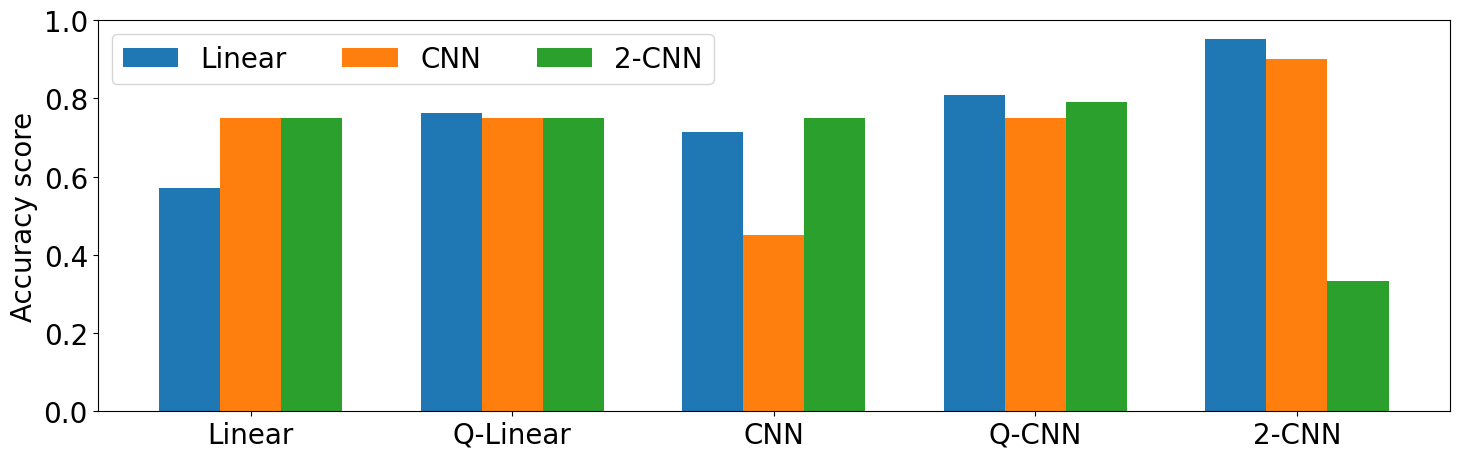

In [232]:
labels = ['Linear', 'Q-Linear', 'CNN', 'Q-CNN', '2-CNN']
adv_linear = [acc_linear_linear, acc_qlinear_linear, acc_cnn_linear, acc_qcnn_linear, acc_cnn2_linear]
adv_cnn = [acc_linear_cnn, acc_qlinear_cnn, acc_cnn_cnn, acc_qcnn_cnn, acc_cnn2_cnn]
adv_cnn2 = [acc_linear_cnn2, acc_qlinear_cnn2, acc_cnn_cnn2, acc_qcnn_cnn2, acc_cnn2_cnn2]

plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3})

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/3, adv_linear, width/3, label='Linear')
rects2 = ax.bar(x, adv_cnn, width/3, label='CNN')
rects3 = ax.bar(x + width/3, adv_cnn2, width/3, label='2-CNN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)
plt.legend(ncol = 3)
fig.tight_layout()
plt.savefig(SAVE_PATH + '/figures/adv_bar.pdf', bbox_inches='tight', dpi=350)
plt.show()